- NVIDIA GeForce GTX 1060 6GB
- Pytorch 1.4.0
- model EfficientNet-B3
- image size 128x128
- batch size 64
- 0-folds
- 10 epochs
- augmentation rotate 4.5
- optimizer over 9000
- one cycle learning rate

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import cv2
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import warnings
warnings.filterwarnings("ignore")

from crop_resize import read_feathers

In [2]:
model_name = 'efficientnet-b3'
pretrained_model_name = './20200308_fold0_no_aug_0-1/efficientnet-b3_29.pth'
image_size = 128
batch_size = 64
random_state = 2020
n_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

in_dir = Path('../input/bengaliai-cv19')
feather_dir = Path('../input/bengaliai-cv19-feather')
out_dir = Path('./20200310_mixup')

cuda:0


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 2020
seed_everything(SEED)

<a id="images"></a>
# Images

In [4]:
filenames = [feather_dir/f'train_image_data_1x{image_size}x{image_size}_{i}.feather' for i in range(4)]
images = read_feathers(filenames, image_size)
print(images.shape)

(200840, 1, 128, 128)


<a id="labels"></a>
# Labels

In [5]:
train_label = pd.read_csv(in_dir/'train.csv')
labels = train_label[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
print(labels.shape)

(200840, 3)


<a id="dataset"></a>
# Dataset

In [6]:
from torch.utils.data import Dataset

class GraphemeDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.train = labels is not None
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = image / image.max()
        if self.transform:
            image_size = image.shape[1]
            image = self.transform(image=image[0])['image']
            image = image.reshape(-1, image_size, image_size)
        if self.train:
            label = self.labels[idx]
            return image, label[0], label[1], label[2]
        else:
            return image

In [7]:
train_dataset = GraphemeDataset(images, labels)
print(len(train_dataset))

200840


<a id="visualize"></a>
# Visualize

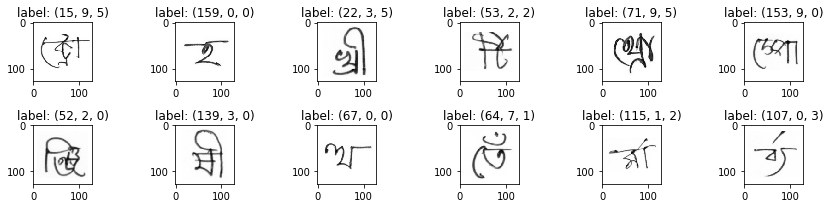

In [8]:
nrow, ncol = 2, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label1, label2, label3 = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label1, label2, label3}')
plt.tight_layout()
plt.show()

<a id="dataloader"></a>
# DataLoader

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('train loader length', len(train_loader))

train loader length 3139


<a id="mixup"></a>
# Mixup

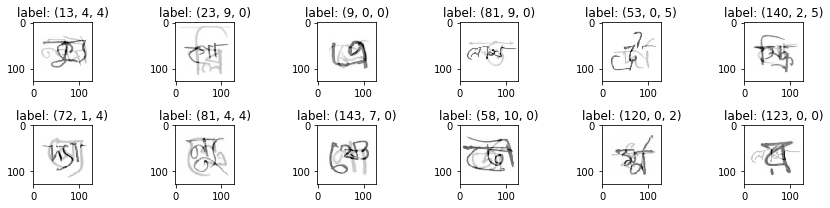

In [10]:
from mix_augmentations import mixup

testloader = iter(train_loader)
inputs, labels1, labels2, labels3 = testloader.next()
mixed_data, _, _, _, _ = mixup(inputs, labels1, labels2, labels3, 1.0)

nrow, ncol = 2, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(mixed_data[i][0], cmap='Greys')
    ax.set_title(f'label: {labels1[i].item(), labels2[i].item(), labels3[i].item()}')
plt.tight_layout()
plt.show()

<a id="model"></a> 
# Model

In [11]:
from my_efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained(model_name, in_channels=1).to(device)
model.load_state_dict(torch.load(pretrained_model_name))

Loaded pretrained weights for efficientnet-b3


<All keys matched successfully>

<a id="optimizer"></a> 
# Optimizer

In [12]:
from optimizer.ralamb import Ralamb
from optimizer.lookahead import Lookahead

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

In [13]:
optimizer =Over9000(model.parameters(), lr=2e-3, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=None, epochs=n_epochs, 
                                                steps_per_epoch=len(train_loader), pct_start=0.0, anneal_strategy='cos', 
                                                cycle_momentum=True, base_momentum=0.85, max_momentum=0.95,  div_factor=100.0)

<a id="loss"></a> 
# loss

In [14]:
from torch import nn
from mix_augmentations import mixup_criterion

criterion = nn.CrossEntropyLoss()

<a id="metrics"></a> 
# Metrics

In [15]:
from metrics import macro_recall_multi
from mix_augmentations import mix_recall_multi

<a id="train"></a> 
# Train

In [16]:
history = pd.DataFrame()

for epoch in range(n_epochs):
    
    # --- training start ---
    torch.cuda.empty_cache()
    gc.collect()
    
    running_loss1, running_loss2, running_loss3 = 0.0, 0.0, 0.0
    running_acc1, running_acc2, running_acc3 = 0.0, 0.0, 0.0
    running_recall = 0.0
    
    train_loss1, train_loss2, train_loss3 = 0.0, 0.0, 0.0
    train_acc1, train_acc2, train_acc3 = 0.0, 0.0, 0.0
    train_loss, train_acc, train_recall = 0.0, 0.0, 0.0
    
    model.train()
    
    # training loop
    for idx, (inputs, labels1, labels2, labels3) in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        # to GPU
        inputs, labels1, labels2, labels3 = inputs.float().to(device), labels1.to(device), labels2.to(device), labels3.to(device)
        
        if np.random.rand() <= 0.5:
            # mixup
            mixed_inputs, sh_labels1, sh_labels2, sh_labels3, lam = mixup(inputs, labels1, labels2, labels3, 1.0)
            
            # to GPU
            mixed_inputs = mixed_inputs.float().to(device)
            sh_labels1, sh_labels2, sh_labels3 = sh_labels1.to(device), sh_labels2.to(device), sh_labels3.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward (on GPU)
            outputs1, outputs2, outputs3 = model(mixed_inputs)
            
            # loss
            loss1 = lam * criterion(outputs1, labels1) + (1 - lam) * criterion(outputs1, sh_labels1)
            loss2 = lam * criterion(outputs2, labels2) + (1 - lam) * criterion(outputs2, sh_labels2)
            loss3 = lam * criterion(outputs3, labels3) + (1 - lam) * criterion(outputs3, sh_labels3)
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            running_loss3 += loss3.item()
            
            # accuracy
            running_acc1 += lam * (outputs1.argmax(1)==labels1).float().mean() + (1 - lam) * (outputs1.argmax(1)==sh_labels1).float().mean()
            running_acc2 += lam * (outputs2.argmax(1)==labels2).float().mean() + (1 - lam) * (outputs2.argmax(1)==sh_labels2).float().mean()
            running_acc3 += lam * (outputs3.argmax(1)==labels3).float().mean() + (1 - lam) * (outputs3.argmax(1)==sh_labels3).float().mean()
            
            # recall
            running_recall += mix_recall_multi(outputs1, labels1, sh_labels1, outputs2, labels2, sh_labels2, outputs3, labels3, sh_labels3, lam)
            
            # backward (on GPU)
            (0.8 * loss1 + 0.1 * loss2 + 0.1 * loss3).backward()
            
        else:
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward (on GPU)
            outputs1, outputs2, outputs3 = model(inputs)
        
            # loss
            loss1 = criterion(outputs1, labels1)
            loss2 = criterion(outputs2, labels2)
            loss3 = criterion(outputs3, labels3)
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            running_loss3 += loss3.item()
        
            # accuracy
            running_acc1 += (outputs1.argmax(1)==labels1).float().mean()
            running_acc2 += (outputs2.argmax(1)==labels2).float().mean()
            running_acc3 += (outputs3.argmax(1)==labels3).float().mean()
        
            # recall
            running_recall += macro_recall_multi(outputs1, labels1, outputs2, labels2, outputs3, labels3)
        
            # backward (on GPU)
            (0.8 * loss1 + 0.1 * loss2 + 0.1 * loss3).backward()
        
        # optimize
        optimizer.step()
        scheduler.step()
    
    # loss, accuracy, recall
    train_loss1 = running_loss1 / len(train_loader)
    train_loss2 = running_loss2 / len(train_loader)
    train_loss3 = running_loss3 / len(train_loader)
    train_loss = 0.5 * train_loss1 + 0.25 * train_loss2 + 0.25 * train_loss3
    train_acc1 = running_acc1 / len(train_loader)
    train_acc2 = running_acc2 / len(train_loader)
    train_acc3 = running_acc3 / len(train_loader)
    train_acc = (train_acc1 + train_acc2 + train_acc3) / 3
    train_recall = running_recall / len(train_loader)
    
    # log
    print('train epoch : {}'.format(epoch))
    print('loss   : {:.4f}, loss1 : {:.4f}, loss2 : {:.4f}, loss3 : {:.4f}'.format(train_loss, train_loss1, train_loss2, train_loss3))
    print('acc    : {:.4f}, acc1  : {:.4f}, acc2  : {:.4f}, acc3  : {:.4f}'.format(train_acc, train_acc1, train_acc2, train_acc3))
    print('recall : {:.4f}'.format(train_recall))
    
    # history
    history.loc[epoch, 'train/loss'] = train_loss
    history.loc[epoch, 'train/loss1'] = train_loss1
    history.loc[epoch, 'train/loss2'] = train_loss2
    history.loc[epoch, 'train/loss3'] = train_loss3
    history.loc[epoch, 'train/acc'] = train_acc.cpu().numpy()
    history.loc[epoch, 'train/acc1'] = train_acc1.cpu().numpy()
    history.loc[epoch, 'train/acc2'] = train_acc2.cpu().numpy()
    history.loc[epoch, 'train/acc3'] = train_acc3.cpu().numpy()
    history.loc[epoch, 'train/recall'] = train_recall
    history.loc[epoch, 'lr'] = scheduler.get_lr()[0]
    
    torch.save(model.state_dict(), out_dir/f'{model_name}_{epoch}.pth')

history.to_csv(out_dir/'history.csv')


train epoch : 0
loss   : 0.7549, loss1 : 1.0251, loss2 : 0.6107, loss3 : 0.3588
acc    : 0.8654, acc1  : 0.8315, acc2  : 0.8592, acc3  : 0.9055
recall : 0.8285



train epoch : 1
loss   : 0.6433, loss1 : 0.8983, loss2 : 0.4797, loss3 : 0.2968
acc    : 0.8633, acc1  : 0.8275, acc2  : 0.8596, acc3  : 0.9028
recall : 0.8212



train epoch : 2
loss   : 0.6383, loss1 : 0.8859, loss2 : 0.4813, loss3 : 0.3003
acc    : 0.8559, acc1  : 0.8179, acc2  : 0.8519, acc3  : 0.8979
recall : 0.8101



train epoch : 3
loss   : 0.5927, loss1 : 0.8143, loss2 : 0.4546, loss3 : 0.2876
acc    : 0.8594, acc1  : 0.8234, acc2  : 0.8551, acc3  : 0.8996
recall : 0.8142



train epoch : 4
loss   : 0.5800, loss1 : 0.7899, loss2 : 0.4525, loss3 : 0.2875
acc    : 0.8578, acc1  : 0.8222, acc2  : 0.8535, acc3  : 0.8977
recall : 0.8125



train epoch : 5
loss   : 0.5599, loss1 : 0.7578, loss2 : 0.4435, loss3 : 0.2804
acc    : 0.8588, acc1  : 0.8235, acc2  : 0.8537, acc3  : 0.8992
recall : 0.8134



train epoch : 6
loss   : 0.5439, loss1 : 0.7308, loss2 : 0.4371, loss3 : 0.2770
acc    : 0.8599, acc1  : 0.8257, acc2  : 0.8540, acc3  : 0.8999
recall : 0.8152



train epoch : 7
loss   : 0.5273, loss1 : 0.7037, loss2 : 0.4288, loss3 : 0.2729
acc    : 0.8612, acc1  : 0.8279, acc2  : 0.8552, acc3  : 0.9003
recall : 0.8178



train epoch : 8
loss   : 0.4952, loss1 : 0.6548, loss2 : 0.4114, loss3 : 0.2598
acc    : 0.8661, acc1  : 0.8346, acc2  : 0.8597, acc3  : 0.9039
recall : 0.8239



train epoch : 9
loss   : 0.4854, loss1 : 0.6387, loss2 : 0.4064, loss3 : 0.2576
acc    : 0.8670, acc1  : 0.8364, acc2  : 0.8607, acc3  : 0.9040
recall : 0.8258



train epoch : 10
loss   : 0.4698, loss1 : 0.6155, loss2 : 0.3962, loss3 : 0.2521
acc    : 0.8688, acc1  : 0.8386, acc2  : 0.8620, acc3  : 0.9059
recall : 0.8280



train epoch : 11
loss   : 0.4766, loss1 : 0.6205, loss2 : 0.4073, loss3 : 0.2579
acc    : 0.8629, acc1  : 0.8317, acc2  : 0.8555, acc3  : 0.9015
recall : 0.8217



train epoch : 12
loss   : 0.4441, loss1 : 0.5748, loss2 : 0.3832, loss3 : 0.2435
acc    : 0.8714, acc1  : 0.8423, acc2  : 0.8645, acc3  : 0.9075
recall : 0.8327



train epoch : 13
loss   : 0.4537, loss1 : 0.5855, loss2 : 0.3946, loss3 : 0.2491
acc    : 0.8673, acc1  : 0.8376, acc2  : 0.8593, acc3  : 0.9050
recall : 0.8273



train epoch : 14
loss   : 0.4485, loss1 : 0.5765, loss2 : 0.3920, loss3 : 0.2489
acc    : 0.8665, acc1  : 0.8370, acc2  : 0.8584, acc3  : 0.9040
recall : 0.8270



train epoch : 15
loss   : 0.4349, loss1 : 0.5566, loss2 : 0.3833, loss3 : 0.2433
acc    : 0.8692, acc1  : 0.8407, acc2  : 0.8609, acc3  : 0.9058
recall : 0.8305



train epoch : 16
loss   : 0.4359, loss1 : 0.5568, loss2 : 0.3860, loss3 : 0.2441
acc    : 0.8678, acc1  : 0.8390, acc2  : 0.8595, acc3  : 0.9048
recall : 0.8293



train epoch : 17
loss   : 0.4012, loss1 : 0.5110, loss2 : 0.3568, loss3 : 0.2261
acc    : 0.8778, acc1  : 0.8511, acc2  : 0.8703, acc3  : 0.9121
recall : 0.8424



train epoch : 18
loss   : 0.4115, loss1 : 0.5246, loss2 : 0.3668, loss3 : 0.2301
acc    : 0.8734, acc1  : 0.8454, acc2  : 0.8648, acc3  : 0.9099
recall : 0.8360



train epoch : 19
loss   : 0.4143, loss1 : 0.5276, loss2 : 0.3686, loss3 : 0.2333
acc    : 0.8742, acc1  : 0.8469, acc2  : 0.8662, acc3  : 0.9096
recall : 0.8377


In [17]:
history

,train/loss,train/loss1,train/loss2,train/loss3,train/acc,train/acc1,train/acc2,train/acc3,train/recall,lr
0,0.754932,1.025107,0.610730,0.358783,0.865401,0.831501,0.859217,0.905484,0.828516,9.938403e-03
1,0.643276,0.898311,0.479695,0.296786,0.863302,0.827484,0.859585,0.902836,0.821196,9.755206e-03
2,0.638345,0.885894,0.481326,0.300265,0.855907,0.817897,0.851892,0.897932,0.810130,9.454920e-03
3,0.592686,0.814291,0.454585,0.287579,0.859370,0.823360,0.855137,0.899613,0.814239,9.044939e-03
4,0.579969,0.789914,0.452521,0.287528,0.857777,0.822179,0.853452,0.897699,0.812515,8.535358e-03
5,0.559868,0.757791,0.443533,0.280356,0.858794,0.823487,0.853669,0.899227,0.813422,7.938726e-03
6,0.543917,0.730781,0.437133,0.276972,0.859890,0.825730,0.854046,0.899893,0.815196,7.269732e-03
7,0.527269,0.703709,0.428777,0.272880,0.861156,0.827939,0.855230,0.900299,0.817843,6.544850e-03
8,0.495208,0.654811,0.411395,0.259816,0.866059,0.834626,0.859695,0.903857,0.823857,5.781929e-03
9,0.485380,0.638733,0.406436,0.257619,0.867035,0.836364,0.860739,0.904002,0.825765,4.999755e-03


<a id="inference"></a> 
# Inference

In [18]:
from crop_resize import read_parquets

height = 137
width = 236
image_size = 128

filenames = [in_dir/f'test_image_data_{i}.parquet' for i in range(4)]
images = read_parquets(filenames, width, height, image_size)
test_dataset = GraphemeDataset(images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2995.93it/s]


In [19]:
row_id = []
target = []

model.eval()

with torch.no_grad():
    for idx, inputs in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs = inputs.float().cuda()
        outputs1, outputs2, outputs3 = model(inputs)
        p1 = outputs1.argmax(-1).view(-1).cpu()
        p2 = outputs2.argmax(-1).view(-1).cpu()
        p3 = outputs3.argmax(-1).view(-1).cpu()
        row_id += [f'Test_{idx}_grapheme_root', f'Test_{idx}_vowel_diacritic', f'Test_{idx}_consonant_diacritic']
        target += [p1.item(), p2.item(), p3.item()]

sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv(out_dir/'submission.csv', index=False)
sub_df

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
5,Test_1_consonant_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_consonant_diacritic,0
9,Test_3_grapheme_root,115
